<!---
--->

<!---
--->

  <center><font size="6.8">  BANK LOAN CLASSIFICATION  </center></br>
  </br>
  <center><font size="5">  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;-- machine learning with python scikit-learn </center>

# <font size="5"> ABSTRACT:  </font> 
This project classifies a bank loan dataset (Source: IBM) using four machine learning methods (KNN, Decision Tree, Support Vector Machine and Logistic Regression) in python.  Testing result shows that KNN has the best prediction accuracy using the metrics of F1 score.  Results of all four methods are given in the end as well.

# <font size="5"> Contents  </font> 

1. [Part I Data Preparation, Model Training and Development Set Testing](#1)

    * KNN training
    * Decision tree training
    * Support Vector Machine(SVM) training
    * Logistic regression training
    
    
2. [Part II Model Evaluation Using Out-of-sample Test Set](#2)

    * KNN testing
    * Decision tree testing
    * SVM out-of-sample testing
    * Logistic regression out-of-sample testing
    
    
3. [Part III Accuracy Report](#3)

    * Classification accuracy table
    

###  <font size="5">About the Dataset </font>

This dataset contain past loans information. The __loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. Testing set **loan_test.csv** has 54 samples.  They include following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |



In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<!---
#!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
--->

## Part I Data Preparation, Model Training and Development Set Testing<a name="1"></a>

### 1.1 Load Data From CSV File  

In [2]:
df = pd.read_csv('loan_train.csv')
df.shape

(346, 10)

### 1.2 Pre-processing:  Feature selection/extraction

In [3]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# df.groupby(['education'])['loan_status'].value_counts(normalize=True)
Feature = df[['Principal','terms','age','Gender','weekend','effective_date','due_date']]
# Feature = df[['Principal','terms','age','Gender','weekend','effective_date','due_date']]
Feature['loan_duration'] = (Feature.due_date-Feature.effective_date).dt.days
Feature.drop(['effective_date','due_date'],axis=1, inplace=True)
# Feature['dtRatio'] = Feature['loan_duration']/Feature['terms']
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
# plt.plot(Feature.loan_duration/Feature.terms)
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
X = Feature
y = df['loan_status'].values
X= preprocessing.StandardScaler().fit(X).transform(X) 

### 1.3 Train_dev_split_on_training_data

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### 1.4 Classification 

The following will be using four methods to train and test models, namely KNN, Decision Tree, Support Vector Machine and Logistic Regression.

### 1.4.1 K Nearest Neighbor(KNN)


In [5]:
# Train and predict the model
from sklearn.neighbors import KNeighborsClassifier
k=8 #from the plot below we see the highest development set testing accuracy is obtained at k = 8.
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)

In [6]:
print (classification_report(y_test, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_test, yhat),3))

              precision    recall  f1-score   support

           0      0.818     0.964     0.885        56
           1      0.500     0.143     0.222        14

    accuracy                          0.800        70
   macro avg      0.659     0.554     0.554        70
weighted avg      0.755     0.800     0.753        70

jaccard score 0.125


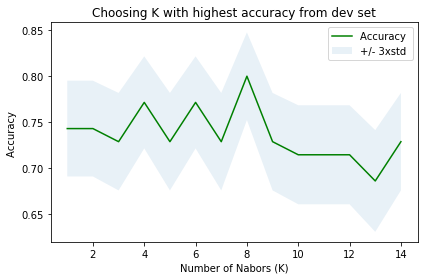

In [7]:
# Try different values of K:
Ks=15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = []
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test,yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
# plot K-Accuracy relationship
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc-1*std_acc,mean_acc +1 * std_acc, alpha=0.1)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.title('Choosing K with highest accuracy from dev set')
plt.tight_layout()
plt.show()

### 1.4.2 Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Training
drugTree = DecisionTreeClassifier(criterion="entropy") #create a tree instance, , max_depth = 4
tree_fit=drugTree.fit(X_train,y_train)


#Prediction
yhat = drugTree.predict(X_test)

In [9]:
# Evaluate accuracy of model
print (classification_report(y_test, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_test, yhat),3))

              precision    recall  f1-score   support

           0      0.815     0.786     0.800        56
           1      0.250     0.286     0.267        14

    accuracy                          0.686        70
   macro avg      0.532     0.536     0.533        70
weighted avg      0.702     0.686     0.693        70

jaccard score 0.154


### 1.4.3 Support Vector Machine

In [10]:
from sklearn import svm
clf = svm.SVC(kernel='rbf') #SVM has many Kernel functions like 1)linear; 2)Polynomial; 3)Radial Basis Function-RBF; 4)Sigmoid
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test) # predict on test set

In [11]:
print (classification_report(y_test, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_test, yhat),3))

              precision    recall  f1-score   support

           0      0.793     0.821     0.807        56
           1      0.167     0.143     0.154        14

    accuracy                          0.686        70
   macro avg      0.480     0.482     0.480        70
weighted avg      0.668     0.686     0.676        70

jaccard score 0.083


### 1.4.4 Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver = 'liblinear').fit(X_train,y_train) # C is inverse lambda, the inverse of regularization term 
yhat = LR.predict(X_test) # predict classes on testset
yhat_prob = LR.predict_proba(X_test) # predict probability on testset: the first column is first class, 2nd Col is 2nd class...

In [13]:
print (classification_report(y_test, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_test, yhat),3))
print("logloss",round(log_loss(y_test, yhat_prob),3))

              precision    recall  f1-score   support

           0      0.800     0.786     0.793        56
           1      0.200     0.214     0.207        14

    accuracy                          0.671        70
   macro avg      0.500     0.500     0.500        70
weighted avg      0.680     0.671     0.676        70

jaccard score 0.115
logloss 0.582


## Part II Model Evaluation Using Test Set<a name="2"></a>

First, download and load the test set:

### 2.1 Load Test set for evaluation 

In [14]:
df2 = pd.read_csv('loan_test.csv')

### 2.2 data preparation for test set

In [15]:
#1. data preparation
df2['due_date'] = pd.to_datetime(df2['due_date'])
df2['effective_date'] = pd.to_datetime(df2['effective_date'])
df2['dayofweek'] = df2['effective_date'].dt.dayofweek
df2['weekend'] = df2['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df2['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature2 = df2[['Principal','terms','age','Gender','weekend','effective_date','due_date']]
Feature2['loan_duration'] = (Feature2.due_date-Feature2.effective_date).dt.days
Feature2.drop(['effective_date','due_date'],axis=1, inplace=True)
# Feature2['dtRatio'] = Feature2['loan_duration']/Feature2['terms']
Feature2 = pd.concat([Feature2,pd.get_dummies(df2['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
df2['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
X_ = Feature2
y_oos = df2['loan_status'].values
X_oos= preprocessing.StandardScaler().fit(X_).transform(X_)

### 2.3 Classification on test sets using different methods 

### 2.3.1 KNN out-of-sample test

In [16]:
yhat = neigh.predict(X_oos)
print (classification_report(y_oos, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_oos, yhat),3))
yhat,y_oos

              precision    recall  f1-score   support

           0      0.765     0.975     0.857        40
           1      0.667     0.143     0.235        14

    accuracy                          0.759        54
   macro avg      0.716     0.559     0.546        54
weighted avg      0.739     0.759     0.696        54

jaccard score 0.133


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

### 2.3.2 Decision Tree out-of-sample test

In [17]:
yhat = drugTree.predict(X_oos)
print (classification_report(y_oos, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_oos, yhat),3))
yhat,y_oos

              precision    recall  f1-score   support

           0      0.829     0.850     0.840        40
           1      0.538     0.500     0.519        14

    accuracy                          0.759        54
   macro avg      0.684     0.675     0.679        54
weighted avg      0.754     0.759     0.756        54

jaccard score 0.35


(array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

### 2.3.3 SVM out-of-sample test

In [18]:
yhat = clf.predict(X_oos)
print (classification_report(y_oos, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_oos, yhat),3))
yhat,y_oos

              precision    recall  f1-score   support

           0      0.804     0.925     0.860        40
           1      0.625     0.357     0.455        14

    accuracy                          0.778        54
   macro avg      0.715     0.641     0.658        54
weighted avg      0.758     0.778     0.755        54

jaccard score 0.294


(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

### 2.3.4 logistic regression out-of-sample test

In [19]:
yhat = LR.predict(X_oos) # predict classes on testset
yhat_prob = LR.predict_proba(X_oos) 
print (classification_report(y_oos, yhat,digits=3)) 
print("jaccard score",round(jaccard_score(y_oos, yhat),3))
print("logloss",round(log_loss(y_oos, yhat_prob),3))
yhat,y_oos

              precision    recall  f1-score   support

           0      0.804     0.925     0.860        40
           1      0.625     0.357     0.455        14

    accuracy                          0.778        54
   macro avg      0.715     0.641     0.658        54
weighted avg      0.758     0.778     0.755        54

jaccard score 0.294
logloss 0.566


(array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

## Part III Accuracy Report<a name="3"></a>
the accuracy of the built model using different evaluation metrics are as follows:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.133       | 0.759        | NA      |
| Decision Tree      | 0.35       | 0.759        | NA      |
| SVM                | 0.294       | 0.778        | NA      |
| LogisticRegression | 0.294       | 0.778        | 0.566       |

<h4>Author:  <a href="https://www.linkedin.com/in/harry-sun-73451112a/">Harry Sun</a></h4>


<hr>

